### 1. Поиск объектов

На изображении страницы необходимо найти местоположение логотипов и подписей. Для их поиска можно использовать как классические (алгоритмические) подходы computervision, так и подходы с использованием нейронных сетей.

На вход подается файл-изображение в формате **\*.tif**. Адрес API и названия параметров для входных данных придумайте самостоятельно.

> В этом ноудбуке обучается модель для поиска `подписей`.

In [26]:
import os
import random
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path
import tensorflow as tf
import random
import pickle

random.seed(1)

In [2]:
# gpu_device = tf.config.experimental.list_physical_devices('GPU')
# if gpu_device:
#     tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [3]:
DATA_ROOT = '../pages/'

class_names = {'Void':0,'DLSignature':1,'DLLogo':2}

IM_SIZE = (600,800) # Все изображения будут приведены этому размеру
win_size = 224  # Будем подавать изображение в нейронную сеть по частям. - это размер квадратного окна прохода.
min_object_size = 20
step_x = 100
step_y = 100

In [4]:
images_path = Path(DATA_ROOT+'source/')
annotation_path = Path(DATA_ROOT+'truth/')

In [5]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [6]:
def generate_df(path):
    anno_list = []
    annotations = filelist(path, '.xml')
    ns = {'doc': "http://lamp.cfar.umd.edu/GEDI"}

    for anno_path in annotations:
        anno = {}
        root = ET.parse(anno_path).getroot()

        document  = root.find('doc:DL_DOCUMENT',ns)

        doc_attrib = document.attrib

        anno['doc_name'] = Path(str(images_path) + '/'+ doc_attrib['src'])
        anno['pages'] = doc_attrib['NrOfPages']
        #=================================================================#
        page = document.find('doc:DL_PAGE',ns)
        page_attrib = page.attrib
        anno['page_id'] = page_attrib['pageID']
        anno['width'] = int(page_attrib['width'])
        anno['height'] = int(page_attrib['height'])
        #=================================================================#

        zone = page.find('doc:DL_ZONE',ns)

        if zone is not None:
            zone_attrib = zone.attrib

            anno['zone_type'] = zone_attrib['gedi_type']
            anno['zone_col'] = int(zone_attrib['col'])
            anno['zone_row'] = int(zone_attrib['row']) 
            anno['zone_width'] = int(zone_attrib['width'])
            anno['zone_height'] = int(zone_attrib['height'])
 
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [7]:
df = generate_df(annotation_path)
df.head(3)

,doc_name,pages,page_id,width,height,zone_type,zone_col,zone_row,zone_width,zone_height
0,../pages/source/mcm24f00_2.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
1,../pages/source/nsr05f00_2.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
2,../pages/source/adh36e00-page2_2.tif,1,1,2560,3246,DLSignature,1232.0,2399.0,896.0,431.0


In [8]:
# Заполним пропуски. 
df.loc[(df['zone_type'].isnull()),'zone_type'] = 'Void'

# Приведем все классы к цыфровому виду.
df['zone_type'] = df['zone_type'].apply(lambda x: class_names[x])

Функции для обработки изображений и извлечения bounding-box

In [9]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BAYER_BG2GRAY)

def create_mask(bb, x, class_index):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows, cols, _ = x.shape
    y_ind = np.zeros((rows, cols)) # Нужно больше каналов.
    y_cat = np.zeros((rows, cols , len(class_names)-1))
    bb = bb.astype(np.int)

    if class_index > 0:
        y_ind[bb[1]:bb[3]+bb[1],bb[0]: bb[2]+bb[0]] = class_index # У нас два класса. И, для каждого из них нужно сделать маску.
        y_cat[bb[1]:bb[3]+bb[1],bb[0]: bb[2]+bb[0], class_index-1] = 1
    return y_cat, y_ind

def create_bb_array(x,class_index):
    """Генерируем массив bounding box'a из столбца train_df"""
    if class_index == 0:
        res = np.array([-1,-1,-1,-1]) 
    else:
        res = np.array([x[0],x[1],x[2],x[3]])      
    return res

def mask_to_bb(mask):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(mask)
    if len(cols)==0:
        bb=[0,-1,-1,-1,-1]
    elif ((np.max(rows)- np.min(rows) < min_object_size) or (np.max(cols)- np.min(cols) < min_object_size)):
        bb=[0,-1,-1,-1,-1]
    else:
        top_row = np.min(rows)
        left_col = np.min(cols)
        bottom_row = np.max(rows)
        right_col = np.max(cols)
        centr_row = (top_row+bottom_row)/2
        centr_col = (left_col+right_col)/2
        bb = [win_size, centr_row, centr_col, bottom_row-top_row, right_col-left_col]
        
    return np.array(bb, dtype=np.float32)/win_size

def resize_image_bb(img_size,img_new_size, bb):
    width, height =  img_size[0], img_size[1]
    new_width, new_height  = img_new_size[0], img_new_size[1]
    height_scale = new_height/height
    width_scale = new_width/width
    bb[0] *= width_scale 
    bb[1] *= height_scale
    bb[2] *= width_scale
    bb[3] *= height_scale
    return bb

## Приведем все изображения к единому размеру. 600x800

In [10]:
new_image_paths = []
new_mask_paths = []
class_index = []
old_width = []
old_height = []
zone_col = []
zone_row = []
zone_width = []
zone_height = []

image_path_resized = Path(DATA_ROOT+'source_prepare')
Path.mkdir(image_path_resized, exist_ok=True)

for index, row in tqdm(df.iterrows()):
    try:
        im_path = Path(row['doc_name'])
        img = cv2.imread(str(im_path))

        img_height = img.shape[0]
        img_width = img.shape[1]

        im_resized = cv2.resize(img, IM_SIZE)
        new_image_path = str(image_path_resized/im_path.parts[-1])
        cv2.imwrite(new_image_path, im_resized)
#=============================================================
        curren_class = row['zone_type']
        bb = create_bb_array(row.values[6:], curren_class)
        bb_resized = resize_image_bb((img_width,img_height),IM_SIZE,bb)
#=============================================================
        col,row, width, height = bb_resized
      
        new_image_paths.append(new_image_path)
        old_height.append(img_height)
        old_width.append(img_width)
        class_index.append(curren_class)
        zone_col.append(col)
        zone_row.append(row)
        zone_width.append(width)
        zone_height.append(height)
        
    except Exception as ex:
        print(index, ex)
    
df_resize = pd.DataFrame({'doc_name':new_image_paths,
                          'old_width': old_width, 'old_height': old_height,
                          'zone_type': class_index, 
                          'zone_col': zone_col, 'zone_row':zone_row, 
                          'zone_width':zone_width, 'zone_height':zone_height})

1000it [00:29, 33.65it/s]


In [11]:
df_resize.head()

,doc_name,old_width,old_height,zone_type,zone_col,zone_row,zone_width,zone_height
0,../pages/source_prepare/mcm24f00_2.tif,1200,1575,0,0.000000,0.000000,0.000000,0.000000
1,../pages/source_prepare/nsr05f00_2.tif,1200,1575,0,0.000000,0.000000,0.000000,0.000000
2,../pages/source_prepare/adh36e00-page2_2.tif,2560,3246,1,288.750000,591.250770,210.000000,106.223044
3,../pages/source_prepare/jon00a00.tif,2504,3111,1,329.233227,637.222758,160.063898,78.174221
4,../pages/source_prepare/byd23a00.tif,1728,2292,1,290.625000,353.926702,104.861111,47.120419


Выделим из сего набора данных только изображения содержащие подписи.

In [12]:
df_signature = df_resize.loc[(df_resize['zone_type']==class_names['DLSignature'])]
df_signature.head(3)

,doc_name,old_width,old_height,zone_type,zone_col,zone_row,zone_width,zone_height
2,../pages/source_prepare/adh36e00-page2_2.tif,2560,3246,1,288.750000,591.250770,210.000000,106.223044
3,../pages/source_prepare/jon00a00.tif,2504,3111,1,329.233227,637.222758,160.063898,78.174221
4,../pages/source_prepare/byd23a00.tif,1728,2292,1,290.625000,353.926702,104.861111,47.120419


Исходное изображение имеет очень большой размер. т.о. оно не помещается в нейронную сеть. Так что оно помещается в нейронную сеть целиком. Для того чтобы обойти это ограничение разрежем изображение на квадраты размером `win_size` (224) c небольшим взаимным перекрытием. И в таком виде будем подавать модель в сеть.

Определим координаты ограничивающий прямоугольников. 

In [13]:
steps_x = math.ceil(IM_SIZE[0]/step_x)
steps_y = math.ceil(IM_SIZE[1]/step_y)

# запомнить позицию каждого квадрата.
win_coords = [ ]
for i in range(steps_y):
    for j in range(steps_x):
        pos_x = step_x*j
        pos_y = step_y*i
        if pos_x+win_size> IM_SIZE[0]:
            pos_x = IM_SIZE[0]-win_size
        if pos_y+win_size> IM_SIZE[1]:
            pos_y = IM_SIZE[1]-win_size   
        win_coords.append([pos_y, pos_x, win_size, win_size])

In [14]:
# Процедура для разбиения изображения на квадраты

def split_image(img, bbx=None, class_index=1):
    is_not_bbx=False
    if not bbx:
        is_not_bbx=True
        bbx = np.array([0,-1,-1,-1,-1], dtype='float')
    _, mask = create_mask(bbx, img, class_index)
# разделем изображение на составные части и возращем кусочки small_imgs and small_bbx
    img_combined = np.concatenate([img, mask[..., None]], axis=2)
    X_batch=[]
    y_batch=[]
    for coord in win_coords:
        combined = img_combined[coord[0]:(coord[0]+coord[2]), coord[1]:(coord[1]+coord[3])]
        X_batch.append(combined[...,:3])
        bb = mask_to_bb(combined[...,3])
        y_batch.append(bb)

    X_batch = np.array(X_batch, dtype='float') /255.0
    y_batch = np.array(y_batch, dtype='float')

    if is_not_bbx:
        return X_batch
    else:    
        return X_batch, y_batch

In [15]:
def show_result(sample_imgs, scores, sample_bbx):
    fig = plt.figure(figsize=(15, 20))
    for j in range(len(sample_imgs)):
        ax = fig.add_subplot(steps_y, steps_x, j+1)
        ax.imshow(sample_imgs[j])
        bb = sample_bbx[j]

        wr = bb[2]*win_size
        hc = bb[3]*win_size
        tr = bb[0]*win_size - wr/2
        tc = bb[1]*win_size - hc/2
        rect = plt.Rectangle((tr, tc), wr, hc,fill=False, color='red')
        ax.add_patch(rect)
        ax.title.set_text(f'{scores[j]:.2f}') 
        plt.xticks([]), plt.yticks([])
    plt.show()

### Генератор. 
 Через него будем подавать изображения в нейронку. Т.к. подаем изображение почастям, то получается так, что буквально 2-3  участка изображения будут содержать логотип, а остальные будут дудут пустыми. Выборка получается несбалансированной. Поэтому применим лайвхак. Будем выбирать только изображения содержащие логотипы и добавлять к ним 3 рандомно выбранные иизображения без объектов.

In [16]:
from albumentations import ShiftScaleRotate

In [17]:
def strong_aug(p=1.0):
    return ShiftScaleRotate(shift_limit=0.3, 
                                     scale_limit=0.3,
                                     rotate_limit=3,
                                     p=p, 
                                     border_mode=cv2.BORDER_CONSTANT)

In [18]:
def keras_generator(gen_df, batch_size = 1, is_test=False,is_augmentation=False):
    c = 0
    ind = np.arange(0,len(gen_df))
    random.shuffle(ind)
    augmentation = strong_aug(p=1.0)

    while True:
        X_batch = []
        y_batch = []

        for i in range(c,c + batch_size): # выполняется до тех пор пока не заполится массив.
          row = gen_df.values[ind[i]] # выдает случайный номер картинки. 
          img_name = row[0]

          class_index = row[3]
          bb = row[4:]
          img = cv2.imread(str(img_name))
          img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

          # создаем маску из bb?,steps_y
          _, mask = create_mask(bb, img, class_index)
          combined = np.concatenate([img, mask[..., None]], axis=2)
          
          if is_test: # Выведем название картинки.
              print(img_name)
              for coord in win_coords:
                combined_chank = combined[coord[0]:(coord[0]+coord[2]), coord[1]:(coord[1]+coord[3])]
                bb = mask_to_bb(combined_chank[...,3])
                X_batch.append(combined_chank[...,:3])
                y_batch.append(bb)
          else:
          #   Будем брать произвольные квадраты, в которых наших изображений нет. 
              max_void_tyles = 3

              while max_void_tyles > 0:
                  i = random.randint(0, len(win_coords)-1)
                  combined_chank = combined[win_coords[i][0]:(win_coords[i][0]+win_coords[i][2]), win_coords[i][1]:(win_coords[i][1]+win_coords[i][3])]
                  bb = mask_to_bb(combined_chank[...,3])
                  if bb[0]== 0:
                    X_batch.append(combined_chank[...,:3])
                    y_batch.append(bb)
                    max_void_tyles-=1
          # Выбираем только box-ы в которых изображение присутствует.
              for coord in win_coords:
                  combined_chank = combined[coord[0]:(coord[0]+coord[2]), coord[1]:(coord[1]+coord[3])]
                  if is_augmentation==True:
                    data = {'image': combined_chank}
                    augmented = augmentation(**data)
                    combined_chank = augmented["image"]
                  bb = mask_to_bb(combined_chank[...,3])
                  if bb[0]==1:
                    X_batch.append(combined_chank[...,:3])
                    y_batch.append(bb)

        X_batch = np.array(X_batch, dtype='float') /255.0
        y_batch = np.array(y_batch, dtype='float')
        
        c += batch_size
        if(c + batch_size >= len(ind)):
            c = 0
            random.shuffle(ind)

        yield X_batch, (y_batch[:,0], y_batch[:,1:])

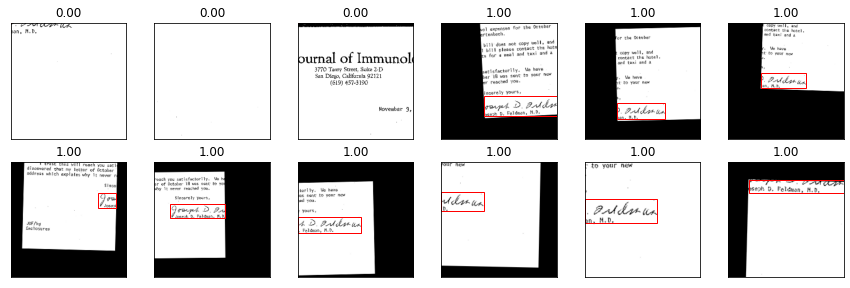

In [19]:
for X_test, y_test in keras_generator(df_signature,batch_size=1,is_augmentation=True):
  break

show_result(X_test, y_test[0],y_test[1])

In [20]:
test_count = math.floor(len(df_signature)*0.2)

train_df_signature = df_signature.iloc[:-test_count]
test_df_signature =  df_signature.iloc[-test_count:]

## Настройка параметров модели. 

In [21]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import matplotlib.patches as patches
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten,Dropout, Input,GlobalAveragePooling2D, BatchNormalization

In [22]:
WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

args = {'padding':'same', 'activation': 'relu','kernel_regularizer':wd}

In [ ]:
base_model = ResNet50(input_shape=(win_size, win_size, 3), include_top=False, pooling='avg')

output = base_model.output

x = Dropout(0.3)(output)
out1 = tf.keras.layers.Dense(1, activation='sigmoid', name='score')(x)
out2 = tf.keras.layers.Dense(4, name='bbx')(x)

model_sign = tf.keras.models.Model(inputs=base_model.input, outputs=[out1, out2])   

In [24]:
def loss(gt, pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,2])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,3])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use 1e-8 to prevent division by zero
    iou = np.round(intersections / (unions + 1e-8), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [25]:
model_sign.compile(optimizer='Adam', 
              loss={'score':'binary_crossentropy', 'bbx':'mse'},
              metrics={'score': 'accuracy', 'bbx':IoU},
              loss_weights={'score': 1.0, 'bbx':10.0})

In [81]:
checkpoint_best_IoU = tf.keras.callbacks.ModelCheckpoint('models/model_sign_resnet_bestIoU.h5',
                                                  monitor='val_bbx_IoU',
                                                  mode='max',
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  save_freq='epoch',
                                                  verbose=1
                                                 )
checkpoint_best_Loss = tf.keras.callbacks.ModelCheckpoint('models/model_sign_resnet_bestLoss.h5',
                                                  monitor='val_loss',
                                                  mode='auto',
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  save_freq='epoch',
                                                  verbose=1
                                                 )

## Тренировка модели.

In [25]:
train_generator = keras_generator(train_df_signature,batch_size=1,is_augmentation=True),
val_generator = keras_generator(train_df_signature,batch_size=1)

steps_per_epoch_training = len(test_df_signature)
steps_val = len(test_df_signature)

In [82]:
NUM_EPOCHS = 100

history = model_sign.fit(train_generator,
                       steps_per_epoch=steps_per_epoch_training,
                       epochs=NUM_EPOCHS,
                       validation_data=val_generator,
                       validation_steps=steps_val, 
                       shuffle=True,
                       callbacks = [checkpoint_best_IoU,checkpoint_best_Loss],
                       verbose=1,
                       )

Epoch 1/100
476/476 [==============================] - 162s 332ms/step - loss: 1.3003 - score_loss: 0.3847 - bbx_loss: 0.0916 - score_accuracy: 0.8278 - bbx_IoU: 0.2048 - val_loss: 2.1448 - val_score_loss: 0.6969 - val_bbx_loss: 0.1448 - val_score_accuracy: 0.3073 - val_bbx_IoU: 0.2597

Epoch 00001: val_bbx_IoU improved from -inf to 0.25967, saving model to models/model_sign_resnet_bestIoU.h5


/home/sergey/anaconda3/envs/imageai_env/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '



Epoch 00001: val_loss improved from inf to 2.14480, saving model to models/model_sign_resnet_bestLoss.h5
Epoch 2/100
476/476 [==============================] - 160s 336ms/step - loss: 0.5233 - score_loss: 0.2141 - bbx_loss: 0.0309 - score_accuracy: 0.9224 - bbx_IoU: 0.2217 - val_loss: 0.9985 - val_score_loss: 0.5527 - val_bbx_loss: 0.0446 - val_score_accuracy: 0.7101 - val_bbx_IoU: 0.2282

Epoch 00002: val_bbx_IoU did not improve from 0.25967

Epoch 00002: val_loss improved from 2.14480 to 0.99849, saving model to models/model_sign_resnet_bestLoss.h5
Epoch 3/100
476/476 [==============================] - 158s 331ms/step - loss: 0.4572 - score_loss: 0.1912 - bbx_loss: 0.0266 - score_accuracy: 0.9273 - bbx_IoU: 0.2170 - val_loss: 0.9210 - val_score_loss: 0.4604 - val_bbx_loss: 0.0461 - val_score_accuracy: 0.7783 - val_bbx_IoU: 0.1193

Epoch 00003: val_bbx_IoU did not improve from 0.25967

Epoch 00003: val_loss improved from 0.99849 to 0.92096, saving model to models/model_sign_resnet_be

In [83]:
model_sign.save(f'models/model_sign_resnet_{NUM_EPOCHS}.h5')

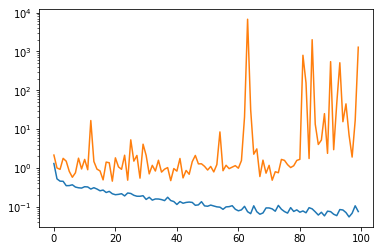

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'] )
plt.semilogy()
plt.show()

In [26]:
model_sign.load_weights('models/model_sign_resnet_bestLoss.h5')

In [ ]:
model_sign.save('../models/model_sign.h5')

In [34]:
# определим реальную позицию прямоугольников и их координаты на изначальном изображении.
# Объединим все bounding box-ы в один.

def combined_bb(win_coords,scores, bbx, threshold=0.9):
    if np.max(scores)< threshold:
        print('low score')
        return [-1,-1,-1,-1]

        
    top_row,left_col,bottom_row,right_col= -1,-1,-1,-1
    counter = 0
    for i, b in enumerate(bbx):
        if (scores[i] >= threshold):
            counter +=1
            box = b * win_size
            box[0] += win_coords[i][1]-box[2]/2  
            box[1] += win_coords[i][0]-box[3]/2
            box[2] += box[0]  
            box[3] += box[1]
            # print(box)
            # if(box[1]< IM_SIZE[1]/2):
            #      continue

            if counter==1:
                top_row = box[0] 
                left_col = box[1]
                bottom_row = box[2]
                right_col = box[3]
            else:
                if(np.abs(top_row - box[0])> win_size/2) or (np.abs(left_col - box[1])> win_size/2):
                    print(np.abs(top_row - box[0]), np.abs(left_col - box[1]) )
                    continue
                top_row = box[0] if box[0] < top_row else top_row
                left_col = box[1] if box[1] < left_col else left_col
                bottom_row = box[2] if box[2] > bottom_row else bottom_row
                right_col = box[3] if box[3] > right_col else right_col

    return [top_row,left_col,bottom_row-top_row,right_col-left_col]

../pages/source_prepare/mzt43f00-page3_3.tif


2021-10-01 16:57:15.076228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-01 16:57:15.150911: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2799925000 Hz
2021-10-01 16:57:18.470744: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-10-01 16:57:26.828082: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8204
2021-10-01 16:57:37.445792: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-01 16:57:44.730453: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


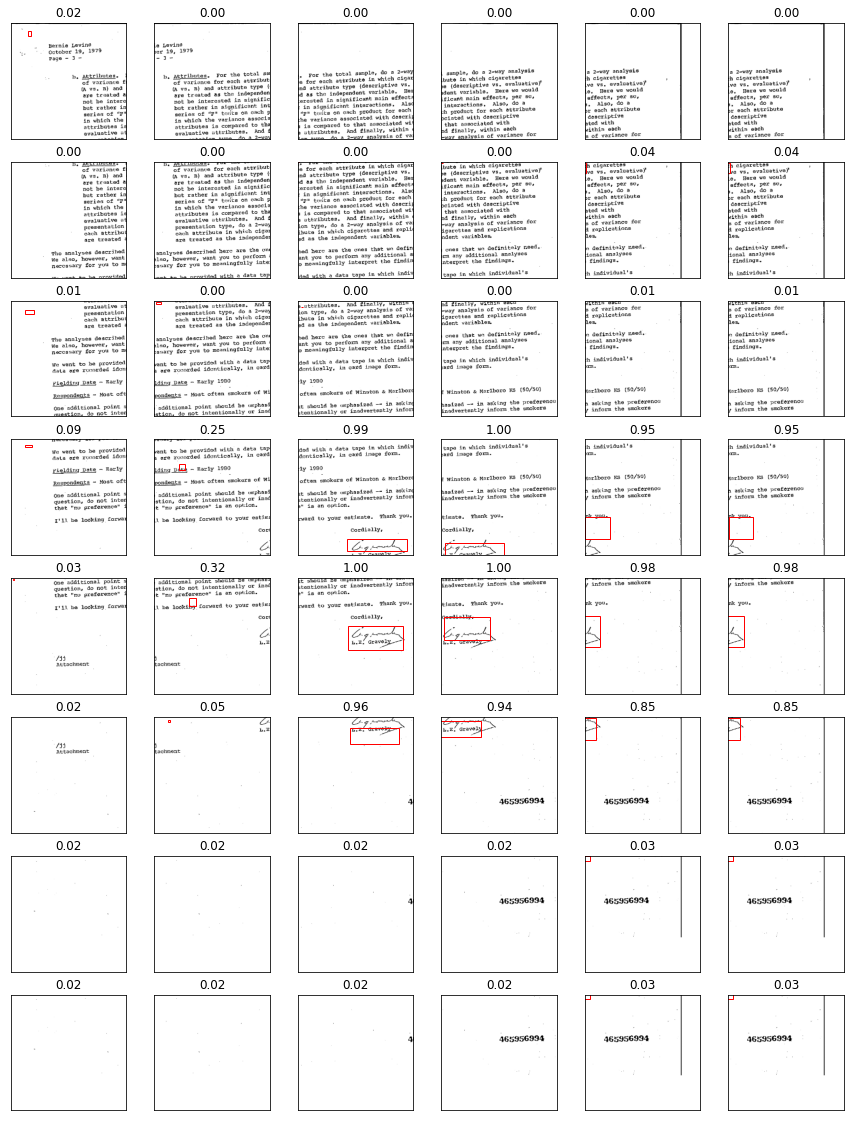

In [29]:
for X_test, y_test in keras_generator(test_df_signature,batch_size=1,is_test=True):
  break

predict = model_sign.predict(X_test)

show_result(X_test,predict[0][:,0], predict[1])

In [ ]:
 '../pages/source_prepare/adh36e00_2.tif',
 '../pages/source_prepare/nuz52d00.tif',
 '../pages/source_prepare/rnf51a00.tif'

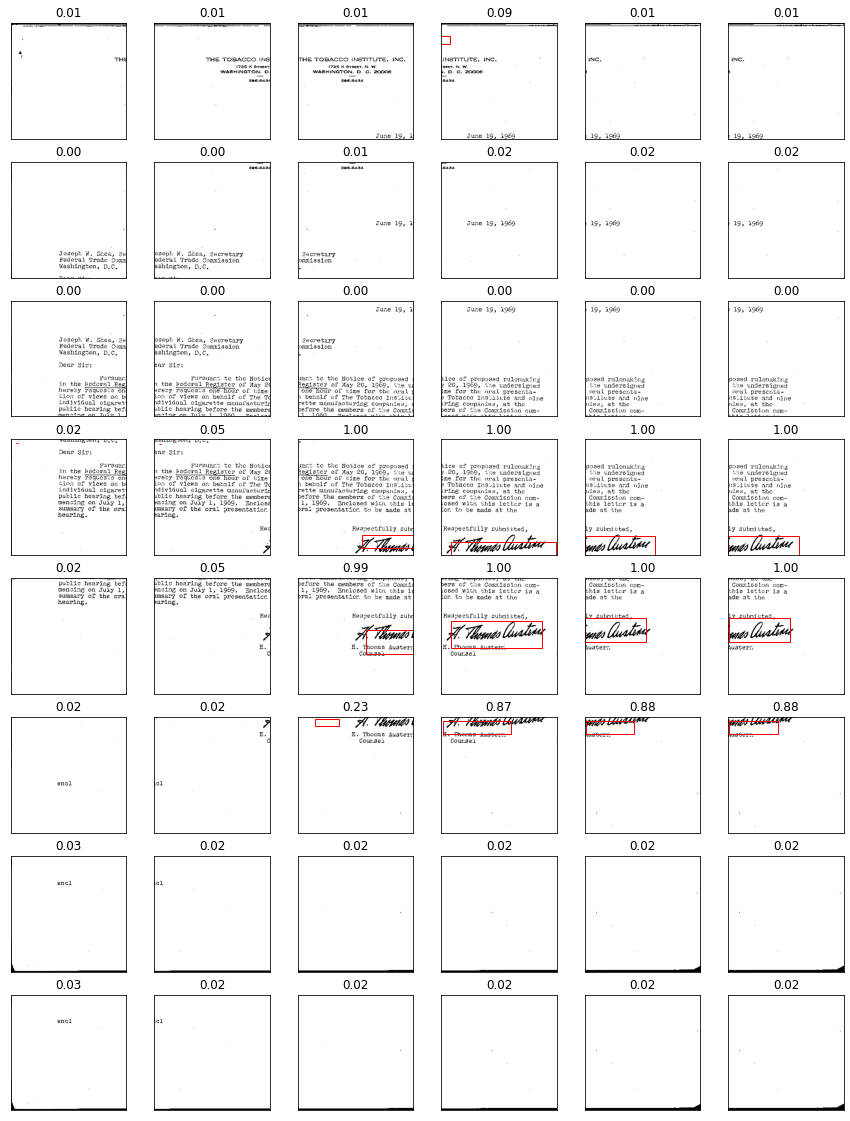

[303.75342, 476.66806, 218.90454, 69.92294]


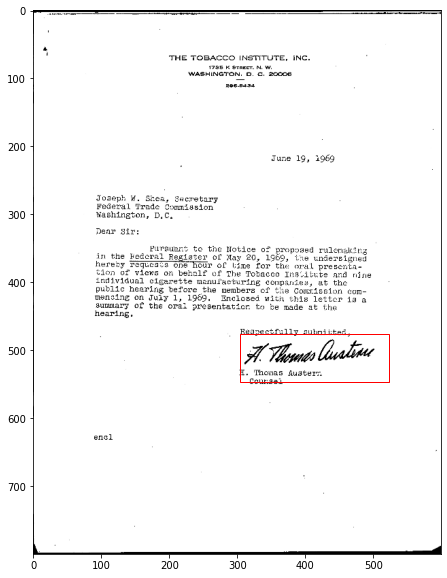

In [63]:
img = cv2.imread('../pages/source_prepare/rnf51a00.tif')
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_list = split_image(img)
predict = model_sign.predict(img_list)
show_result(img_list,predict[0][:,0],predict[1])
# print(predict[0])
# Объединим кусочки в одно изображение.
bb = combined_bb(win_coords, predict[0], predict[1], threshold=0.5)
print(bb)
rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, 'gray', vmin=0, vmax=1,)
ax.add_patch(rect)
plt.show()

### Сохраним модель в формате-pickle.

In [27]:
# model_signature = tf.keras.models.load_model("../models/model_sign.h5", custom_objects={"IoU":IoU})

In [28]:
# Сохранение модели. 
model_dict = {}

model_dict['graph'] = model_signature.to_json()
model_dict['weights'] = model_signature.get_weights()

/home/sergey/anaconda3/envs/imageai_env/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [31]:
with open('../models/model_sign.pickle', 'wb') as f:
    pickle.dump(model_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

### Проверим качество предсказания после того как модель будет восстановлена.

In [32]:
with open('../models/model_sign.pickle', 'rb') as f:
   model_dict_restore = pickle.load(f)
   
model = tf.keras.models.model_from_json(model_dict_restore['graph'], custom_objects={"IoU":IoU})
model.set_weights(model_dict_restore['weights'])

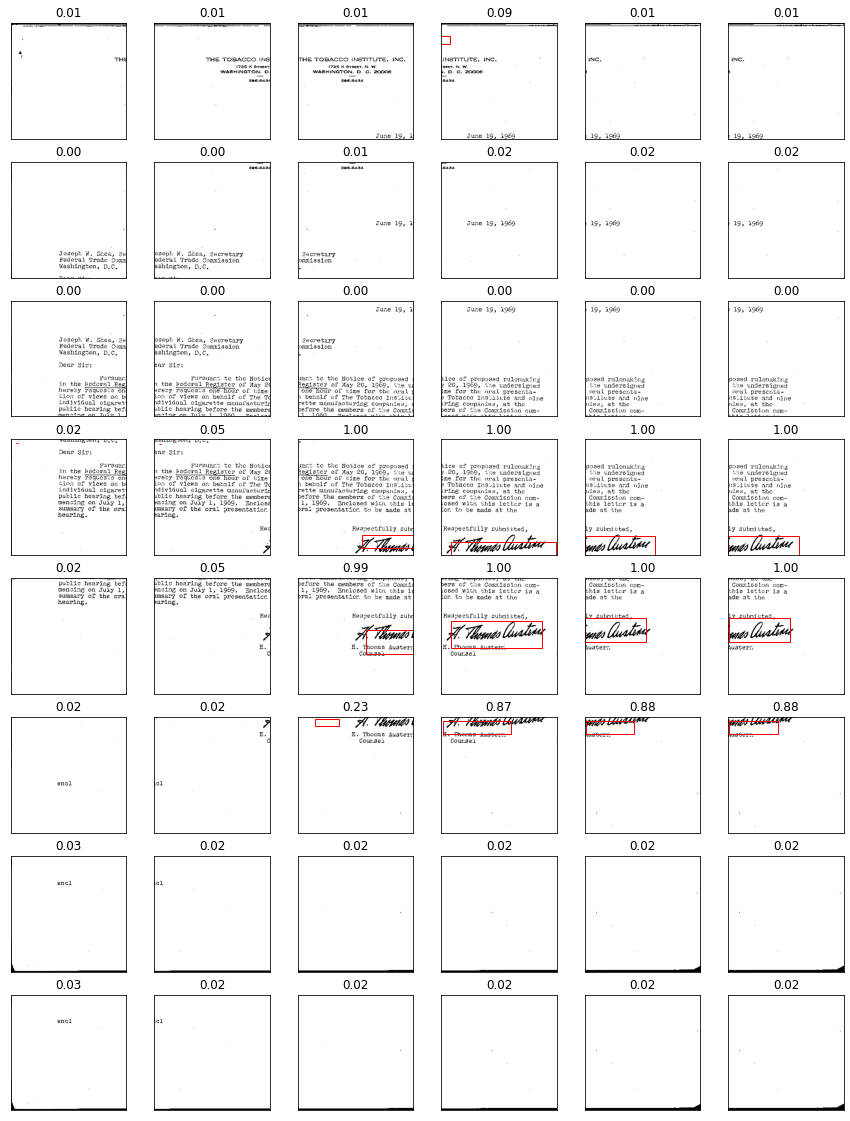

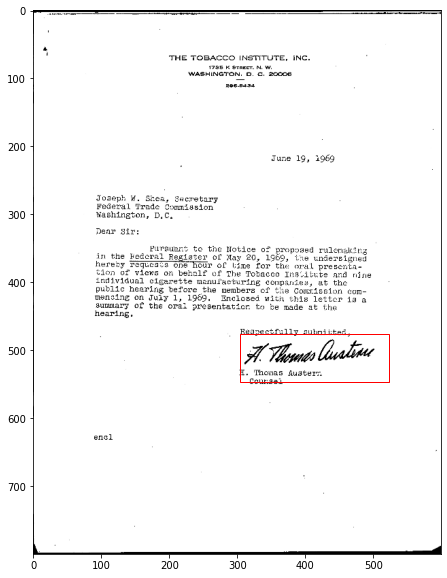

In [35]:
img = cv2.imread('../pages/source_prepare/rnf51a00.tif')
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_list = split_image(img)
predict = model.predict(img_list)
show_result(img_list,predict[0][:,0],predict[1])

# Объединим кусочки в одно изображение.
bb = combined_bb(win_coords, predict[0], predict[1], threshold=0.5)
rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, 'gray', vmin=0, vmax=1,)
ax.add_patch(rect)
plt.show()